In [1]:
#!pip install tf-keras
#!pip install scikit-learn

In [1]:
import os
import shutil
from IPython.display import display
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
#from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import BatchNormalization
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import numpy as np
sys.path.append('aux_scripts.py')

image_size = 299

2025-01-28 11:55:59.677875: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-28 11:55:59.789201: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-28 11:55:59.884349: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738061759.968273    6633 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738061759.994840    6633 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-28 11:56:00.199443: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## NN creation and training

### Split the data into training and validation sets

In [5]:
# Function to clear a directory
def clear_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)  # Remove the directory and its contents
    os.makedirs(directory, exist_ok=True)  # Recreate an empty directory

# Function to copy files to target directories
def copy_files(file_list, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    for file in file_list:
        shutil.copy(file, target_dir)

# Function to split dataset
def split_dataset(source_dir, test_size=0.2):
    files = os.listdir(source_dir)
    files = [os.path.join(source_dir, f) for f in files]
    train_files, temp_files = train_test_split(files, test_size=test_size, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)
    return train_files, val_files, test_files

# Split the dataset
def split_and_copy(train_dir, val_dir, test_dir):

    # Clear the train, val, and test directories before splitting
    clear_directory(train_dir)
    clear_directory(val_dir)
    clear_directory(test_dir)

    mask_train_files, mask_val_files, mask_test_files = split_dataset(mask_dir)
    no_mask_train_files, no_mask_val_files, no_mask_test_files = split_dataset(no_mask_dir)
    wrong_mask_train_files, wrong_mask_val_files, wrong_mask_test_files = split_dataset(wrong_mask_dir)

    # Copy files to train/val/test directories
    copy_files(mask_train_files, os.path.join(train_dir, 'mask'))
    copy_files(mask_val_files, os.path.join(val_dir, 'mask'))
    copy_files(mask_test_files, os.path.join(test_dir, 'mask'))

    copy_files(no_mask_train_files, os.path.join(train_dir, 'no_mask'))
    copy_files(no_mask_val_files, os.path.join(val_dir, 'no_mask'))
    copy_files(no_mask_test_files, os.path.join(test_dir, 'no_mask'))
    
    copy_files(wrong_mask_train_files, os.path.join(train_dir, 'wrong_mask'))
    copy_files(wrong_mask_val_files, os.path.join(val_dir, 'wrong_mask'))
    copy_files(wrong_mask_test_files, os.path.join(test_dir, 'wrong_mask'))

In [6]:
# Paths to directories
dataset_dir = '../dataset'
train_dir = '../dataset_split/train'
val_dir = '../dataset_split/val'
test_dir = '../dataset_split/test'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

mask_dir = os.path.join(dataset_dir, 'mask')
no_mask_dir = os.path.join(dataset_dir, 'no_mask')
wrong_mask_dir = os.path.join(dataset_dir, 'wrong_mask')

split_and_copy(train_dir, val_dir, test_dir)

# Data augmentation and generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(image_size, image_size), batch_size=32, class_mode='categorical')

val_generator = val_datagen.flow_from_directory(val_dir, target_size=(image_size, image_size), batch_size=32, class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir, target_size=(image_size, image_size), batch_size=32, class_mode='categorical', shuffle=False)

Found 3650 images belonging to 3 classes.
Found 456 images belonging to 3 classes.
Found 458 images belonging to 3 classes.


In [ ]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(299, 299, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

# Train the model with callbacks
history = model.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Save the model
model.save('mask_detector_model.h5')
print("Model trained and saved as 'mask_detector_model.h5'")

### Test the model on the test set

Load the model

In [7]:
## load the model
model = tf.keras.models.load_model(f'Conv2_model.h5')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 297, 297, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 297, 297, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 148, 148, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 146, 146, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 71, 71, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 33, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 33, 33, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,925 (273.15 KB)

 Trainable params: 69,571 (271.76 KB)

 Non-trainable params: 352 (1.38 KB)

 Optimizer params: 2 (12.00 B)

## F1-Score and Confusion matrix

In [ ]:
# Get true labels
y_true = test_generator.classes  # True class labels from the test generator

# Get predicted labels
y_pred_probs = model.predict(test_generator)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=-1)     # Convert to class indices

# Class labels (should match the order of your classes in test_generator.class_indices)
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

NameError: name 'test_generator' is not defined

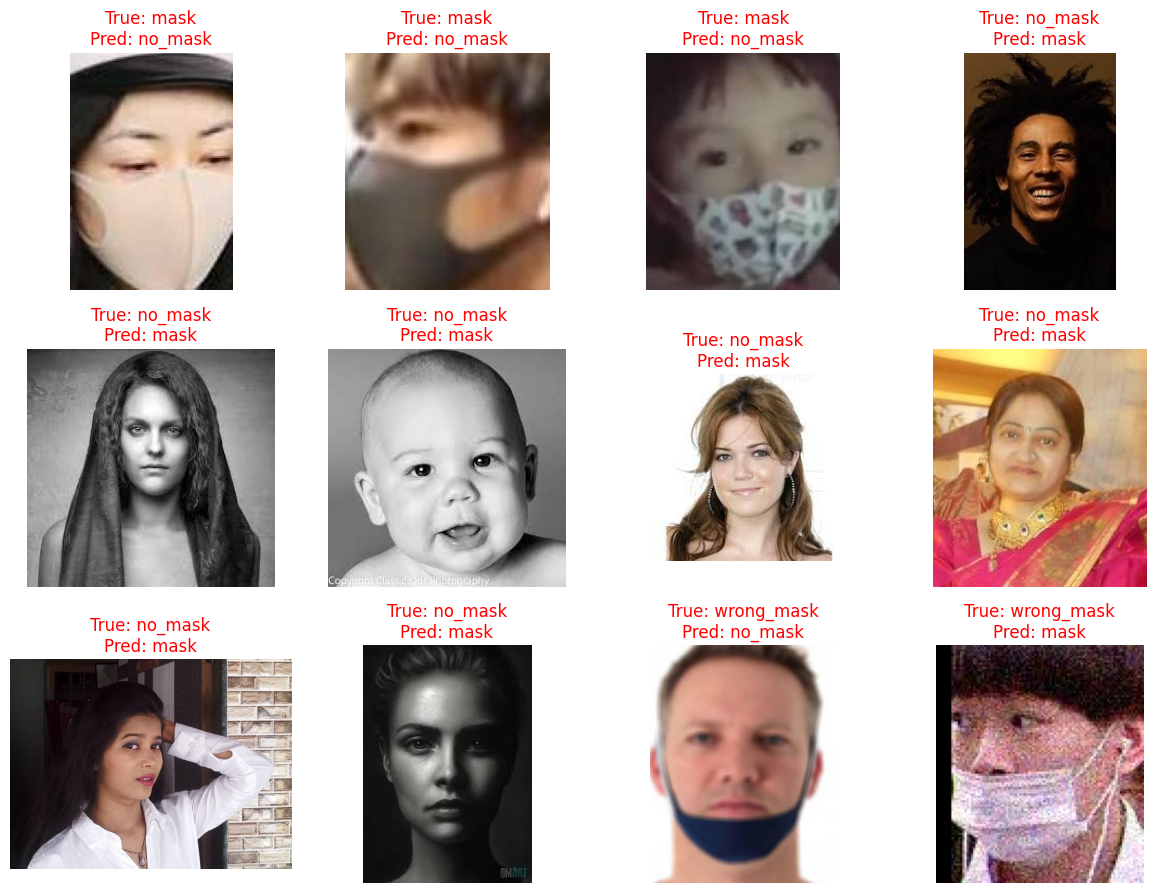

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Find indices of misclassified images
misclassified_indices = np.where(y_true != y_pred)[0]

# Get filepaths of misclassified images
misclassified_filepaths = np.array(test_generator.filepaths)[misclassified_indices]

# True and predicted labels of the misclassified images
misclassified_true_labels = y_true[misclassified_indices]
misclassified_pred_labels = y_pred[misclassified_indices]

In [ ]:


# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Display the misclassified images
plt.figure(figsize=(12, 12))
for i, filepath in enumerate(misclassified_filepaths[:16]):  # Display up to 16 images
    img = plt.imread(filepath)  # Read the image
    true_label = class_labels[misclassified_true_labels[i]]
    pred_label = class_labels[misclassified_pred_labels[i]]
    
    plt.subplot(4, 4, i + 1)  # Arrange images in a grid
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}", color='red' if true_label != pred_label else 'green')
    plt.axis('off')

plt.tight_layout()
plt.show()

Test the model on the test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


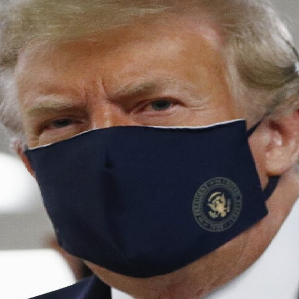

Image: dims.apnews.jpeg_face_1.png - Prediction: Wrong Mask (Probabilities: [0.18215811 0.00395104 0.8138908 ])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


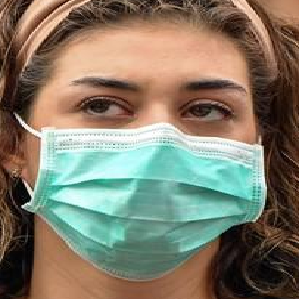

Image: mix_mask_3.jpg_face_1.png - Prediction: Mask (Probabilities: [9.9926370e-01 5.2738128e-06 7.3108554e-04])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


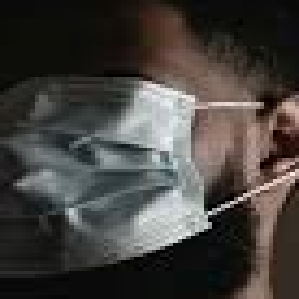

Image: bor_lin2.jpeg_face_1.png - Prediction: Mask (Probabilities: [0.9825028  0.01394072 0.00355649])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


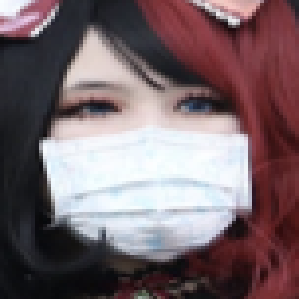

Image: w_mask_2.png_face_2.png - Prediction: Mask (Probabilities: [0.8655592  0.07260333 0.06183735])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


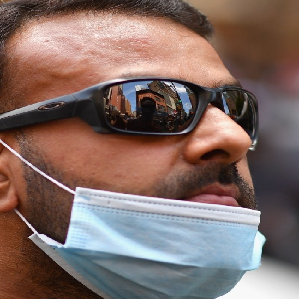

Image: bor_lin14.jpeg_face_1.png - Prediction: Wrong Mask (Probabilities: [1.7008338e-04 2.7986556e-05 9.9980193e-01])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


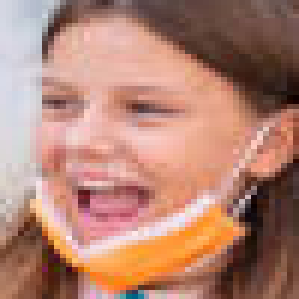

Image: gettyimages-1269940262-612x612.jpg_face_1.png - Prediction: Mask (Probabilities: [0.848945   0.01403887 0.13701618])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


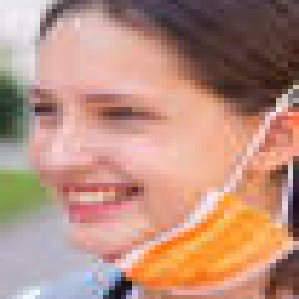

Image: gettyimages-1269940262-612x612.jpg_face_2.png - Prediction: Mask (Probabilities: [0.70115334 0.02304819 0.27579853])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


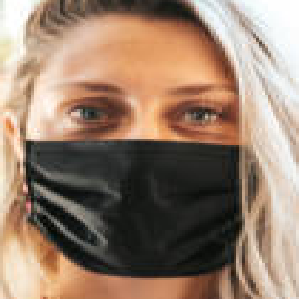

Image: gettyimages-1280412006-612x612.jpg_face_2.png - Prediction: Mask (Probabilities: [0.9270167  0.0255977  0.04738557])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


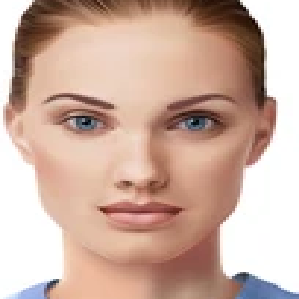

Image: test2.png_face_1.png - Prediction: Wrong Mask (Probabilities: [0.2530393  0.35242084 0.39453983])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


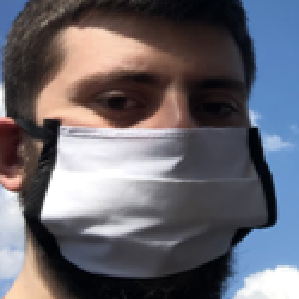

Image: w_mask_1.png_face_1.png - Prediction: Mask (Probabilities: [0.9518253  0.0100013  0.03817335])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


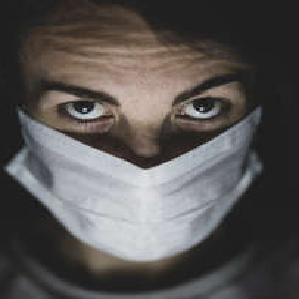

Image: bor_lin5.jpg_face_1.png - Prediction: Mask (Probabilities: [0.98422897 0.01062637 0.0051447 ])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


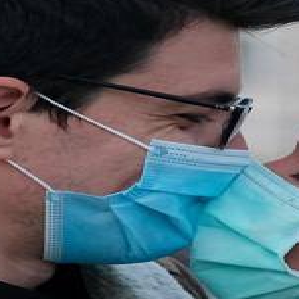

Image: bor_lin6.jpg_face_2.png - Prediction: Mask (Probabilities: [0.61116827 0.00243122 0.3864005 ])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


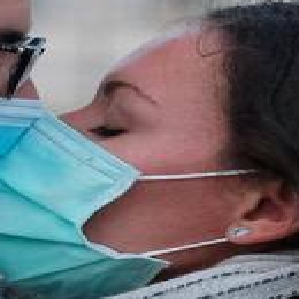

Image: bor_lin6.jpg_face_1.png - Prediction: Mask (Probabilities: [0.6629743  0.00091399 0.33611166])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


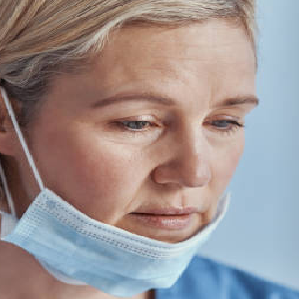

Image: gettyimages-1283003212-612x612.jpg_face_1.png - Prediction: Wrong Mask (Probabilities: [6.0045617e-03 2.8694162e-04 9.9370849e-01])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


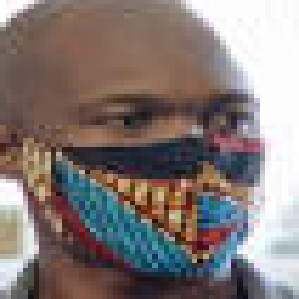

Image: gettyimages-1481643395-612x612.jpg_face_1.png - Prediction: Mask (Probabilities: [9.9597424e-01 3.1230459e-03 9.0270693e-04])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


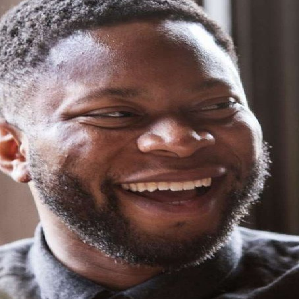

Image: bor_lin10.jpeg_face_1.png - Prediction: No Mask (Probabilities: [0.00588776 0.9784092  0.01570311])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


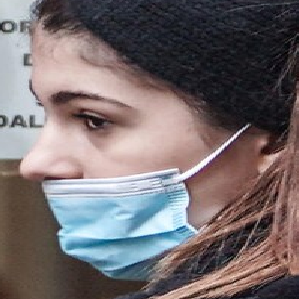

Image: bor_lin7.jpg_face_1.png - Prediction: Wrong Mask (Probabilities: [0.39616236 0.18410823 0.41972947])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


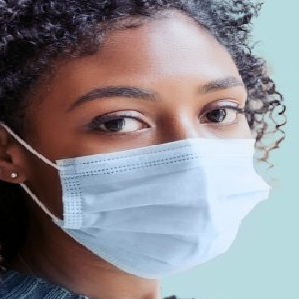

Image: bor_lin1.jpg_face_1.png - Prediction: Mask (Probabilities: [0.7843096 0.001266  0.2144243])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


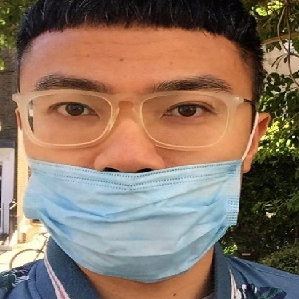

Image: bor_lin13.jpeg_face_1.png - Prediction: Wrong Mask (Probabilities: [1.1724962e-02 4.6101469e-04 9.8781407e-01])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


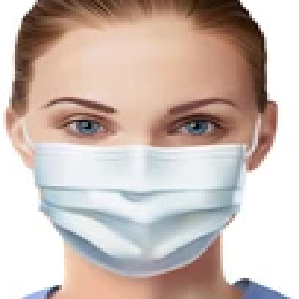

Image: test2.png_face_2.png - Prediction: Mask (Probabilities: [9.9932921e-01 1.0257067e-05 6.6053797e-04])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


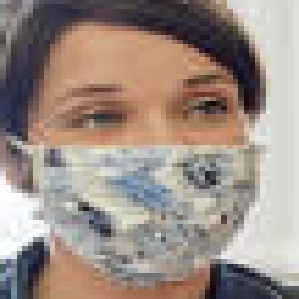

Image: gettyimages-1481643395-612x612.jpg_face_2.png - Prediction: Mask (Probabilities: [9.9857843e-01 2.6462076e-04 1.1569950e-03])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


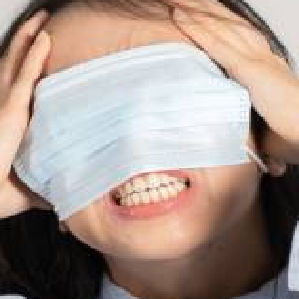

Image: gettyimages-1646342858-612x612.jpg_face_1.png - Prediction: Mask (Probabilities: [0.7651635  0.00435354 0.23048298])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


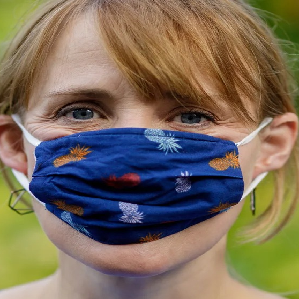

Image: bor_lin15.jpeg_face_1.png - Prediction: Wrong Mask (Probabilities: [7.9340354e-04 3.3639668e-04 9.9887019e-01])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


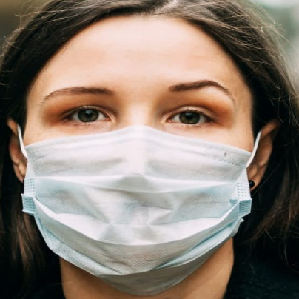

Image: bor_lin11.jpeg_face_1.png - Prediction: Mask (Probabilities: [0.77317995 0.00416158 0.22265851])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


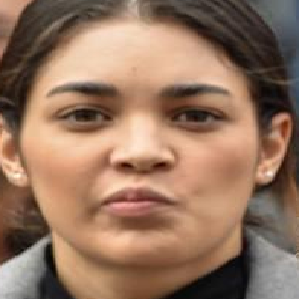

Image: mix_mask_3.jpg_face_2.png - Prediction: No Mask (Probabilities: [3.2377319e-04 9.9866176e-01 1.0144439e-03])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


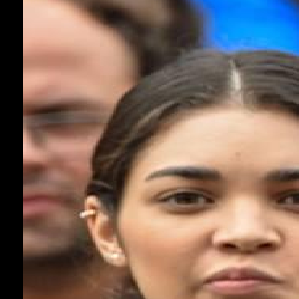

Image: mix_mask_3.jpg_face_4.png - Prediction: No Mask (Probabilities: [2.2686267e-04 9.9885154e-01 9.2156295e-04])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


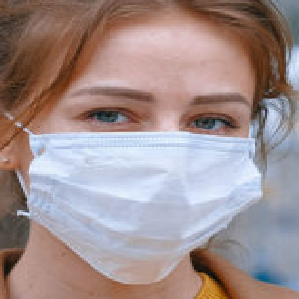

Image: bor_lin9.jpg_face_1.png - Prediction: Mask (Probabilities: [9.5728314e-01 1.4473226e-05 4.2702414e-02])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


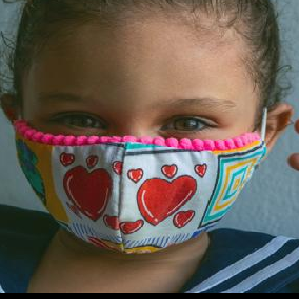

Image: bor_lin8.jpg_face_1.png - Prediction: Mask (Probabilities: [0.88305783 0.02740418 0.08953794])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


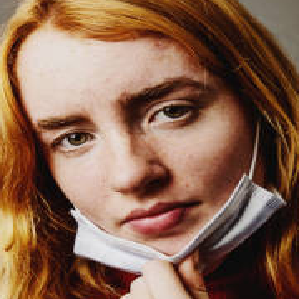

Image: gettyimages-1292019425-612x612.jpg_face_1.png - Prediction: Wrong Mask (Probabilities: [0.03641932 0.45398563 0.5095951 ])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


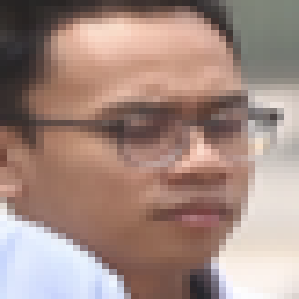

Image: mix_mask_2.png_face_2.png - Prediction: Mask (Probabilities: [9.8529005e-01 1.8858870e-04 1.4521329e-02])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


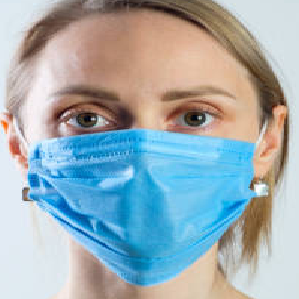

Image: gettyimages-1363608328-612x612.jpg_face_1.png - Prediction: Wrong Mask (Probabilities: [0.23346597 0.00198158 0.7645524 ])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


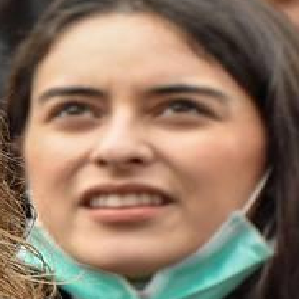

Image: mix_mask_3.jpg_face_3.png - Prediction: No Mask (Probabilities: [5.8947911e-04 9.7901022e-01 2.0400273e-02])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


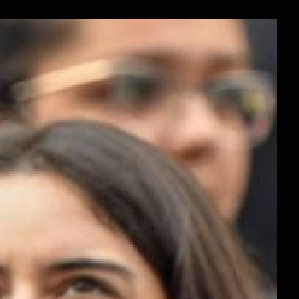

Image: mix_mask_3.jpg_face_5.png - Prediction: Mask (Probabilities: [0.7013804  0.02094687 0.2776727 ])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


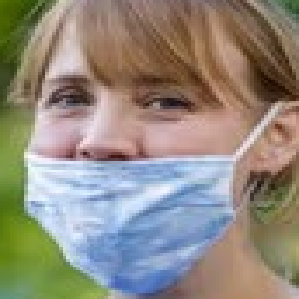

Image: bor_lin16.jpeg_face_1.png - Prediction: Wrong Mask (Probabilities: [3.3759843e-03 4.2634722e-04 9.9619764e-01])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


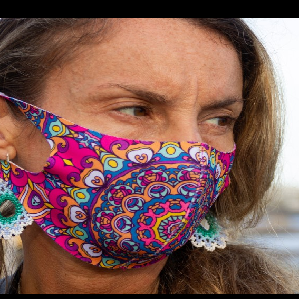

Image: bor_lin3.jpg_face_1.png - Prediction: Mask (Probabilities: [0.84765744 0.00765935 0.1446832 ])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


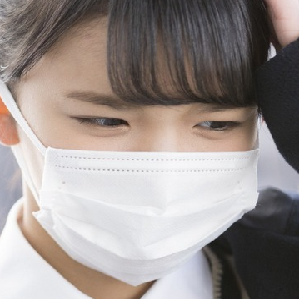

Image: bor_lin18.jpeg_face_1.png - Prediction: Mask (Probabilities: [9.9895096e-01 3.5845504e-05 1.0131181e-03])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


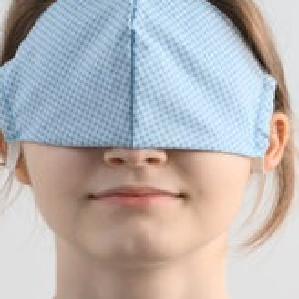

Image: bor_lin12.jpeg_face_1.png - Prediction: Wrong Mask (Probabilities: [0.13296129 0.23358765 0.633451  ])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


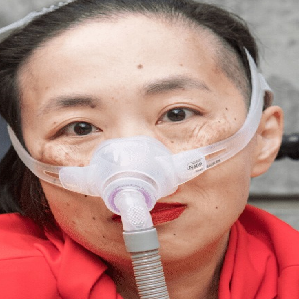

Image: bor_lin17.jpeg_face_1.png - Prediction: Wrong Mask (Probabilities: [0.02101449 0.05038309 0.9286024 ])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


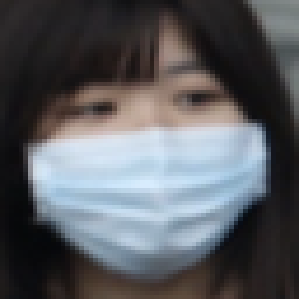

Image: w_mask_2.png_face_1.png - Prediction: Mask (Probabilities: [9.9865437e-01 1.6380411e-05 1.3292071e-03])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


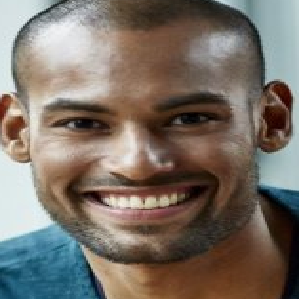

Image: test.jpg_face_1.png - Prediction: No Mask (Probabilities: [0.09750409 0.76211303 0.14038293])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


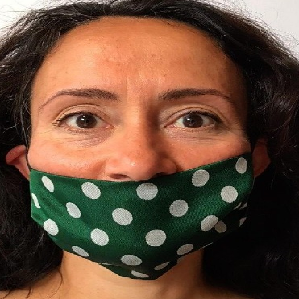

Image: bor_lin13.jpeg_face_2.png - Prediction: Mask (Probabilities: [0.9248504  0.04490989 0.03023973])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


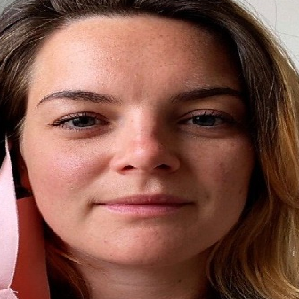

Image: bor_lin13.jpeg_face_3.png - Prediction: No Mask (Probabilities: [0.01093215 0.9014152  0.08765268])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


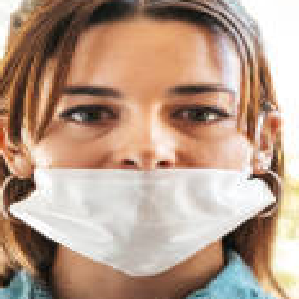

Image: gettyimages-1280412006-612x612.jpg_face_1.png - Prediction: Wrong Mask (Probabilities: [0.06345359 0.01810247 0.918444  ])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


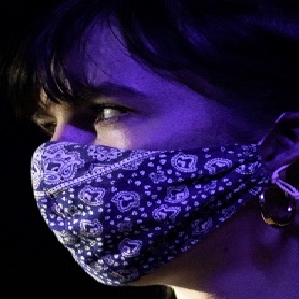

Image: bor_lin4.jpg_face_1.png - Prediction: Mask (Probabilities: [0.57766443 0.42125764 0.0010779 ])
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


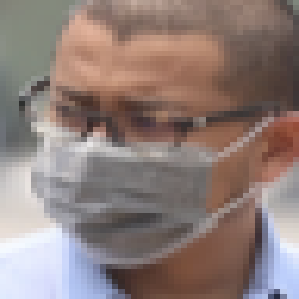

Image: mix_mask_2.png_face_1.png - Prediction: Mask (Probabilities: [9.9844259e-01 1.5719574e-04 1.4001713e-03])


In [10]:
# Folder containing images to test
test_images_folder = '../dataset/images/cropped'  # Update with your folder path

class_labels = ['Mask', 'No Mask', 'Wrong Mask']  # Update class labels accordingly

for image_name in os.listdir(test_images_folder):
    image_path = os.path.join(test_images_folder, image_name)
    # Load and preprocess the image
    img = load_img(image_path, target_size=(image_size, image_size))  # Resize to match input size
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)  # Get class index with highest probability
    label = class_labels[predicted_class]  # Map index to class label
    
    display(img)
    print(f"Image: {image_name} - Prediction: {label} (Probabilities: {prediction[0]})")
